<a href="https://colab.research.google.com/github/appolloford/strong_lensing_simulation/blob/main/Lenstronomy_simulation_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%cd /content
!mkdir pkgs
%cd pkgs
!git clone https://github.com/sibirrer/fastell4py.git
%cd fastell4py
%pip install . --user
%cd ../../
%pip install lenstronomy==1.0.0  # tested with version 1.9.0
%pip install corner schwimmbad

/content
mkdir: cannot create directory ‘pkgs’: File exists
/content/pkgs
fatal: destination path 'fastell4py' already exists and is not an empty directory.
/content/pkgs/fastell4py
Processing /content/pkgs/fastell4py
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for fastell4py: filename=fastell4py-0.1.0-cp37-cp37m-linux_x86_64.whl size=205867 sha256=df09927e33f731b1364c3c7bcc9ba68e760e118e3e1e56697d285bc2d405dc17
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_7is_m7/wheels/68/a9/11/1e31066942c7fb7581c9378feac5225bbd6d428297706af07d
Successfully built fastell4py
  Attempting uninstall: fastell4py
    Found existing instal

/content


In [47]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!mkdir /content/drive/MyDrive/LensingSimData

mkdir: cannot create directory ‘/content/drive/MyDrive/LensingSimData’: File exists


In [49]:
# import of standard python libraries
import os
import time
import corner
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

# import lenstronomy package
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

%matplotlib inline

In [50]:
num_sample = 4
show_img = True
dest_dir = Path("/content/drive/MyDrive/LensingSimData/") if IN_COLAB else Path("LensingSimData")

In [51]:
#  cutout pixel size per axis
#  pixel size in arcsec (area per pixel = deltaPix**2)
numPix, deltaPix = 100, 0.05

In [52]:
# def create_lens_model(config):
#     kwargs_shear = {
#         'gamma_ext': config['gamma_ext'], 
#         'psi_ext': config['psi_ext'],
#     }  # shear values to the source plane
#     kwargs_spemd = {
#         'theta_E': config['theta_E'], 
#         'gamma': config['gamma'], 
#         'center_x': config['center_x'], 
#         'center_y': config['center_y'], 
#         'e1': config['e1'], 
#         'e2': config['e2'],
#     }  # parameters of the deflector lens model

#     kwargs_maps = {
#         'SPEMD': kwargs_spemd,
#         'SHEAR_GAMMA_PSI': kwargs_shear,
#     }

#     # the lens model is a supperposition of an elliptical lens model with external shear
#     res = {
#         'kwargs_list': [kwargs_maps[key] for key in kwargs_maps],
#         'class': LensModel(lens_model_list=config['model_list']),
#     }
#     return res



def create_light_model(
        phi_G, 
        q, 
        R_sersic_mu, 
        R_sersic_sigma, 
        n_sersic_mu, 
        n_sersic_sigma, 
        amp, 
        center_x, 
        center_y, 
        model_list,
    ):
    e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
    R_sersic = np.random.normal(R_sersic_mu, R_sersic_sigma)
    n_sersic = np.random.normal(n_sersic_mu, n_sersic_sigma)

    kwargs = {
        'amp': amp,
        'R_sersic': R_sersic,
        'n_sersic': n_sersic,
        'e1': e1,
        'e2': e2,
        'center_x': center_x,
        'center_y': center_y,
    }

    light_model = LightModel(light_model_list=model_list)
    light_model_kwargs = [kwargs]

    return light_model, light_model_kwargs


def create_point_source_model(lens_model, lens_model_kwargs, source_position):
    lensEquationSolver = LensEquationSolver(lens_model)
    x_image, y_image = lensEquationSolver.findBrightImage(
        source_position['x'], 
        source_position['y'], 
        lens_model_kwargs, 
        numImages = 4,
        min_distance = deltaPix, 
        search_window = numPix * deltaPix,
    )
    mag = lens_model.magnification(x_image, y_image, kwargs=lens_model_kwargs)

    # quasar point source position in the source plane and intrinsic brightness
    kwargs = {
        'ra_image': x_image, 
        'dec_image': y_image,
        'point_amp': np.abs(mag) * 1000,
    }  
    point_source_model = PointSource(
        point_source_type_list=['LENSED_POSITION'], 
        fixed_magnification_list=[False],
    )

    point_source_model_kwargs = [kwargs]

    return point_source_model, point_source_model_kwargs


def plot_image(img):
    cmap_string = 'gray'
    cmap = plt.get_cmap(cmap_string)
    cmap.set_bad(color='k', alpha=1.)
    cmap.set_under('k')

    v_min = -4
    v_max = 2

    f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
    ax = axes
    im = ax.matshow(np.log10(img), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

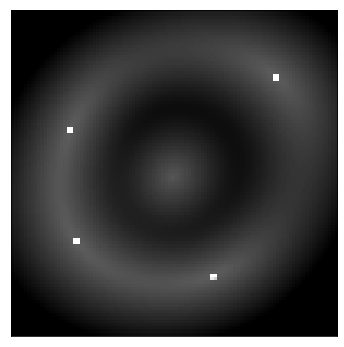

 25%|██▌       | 1/4 [00:00<00:00,  5.67it/s]

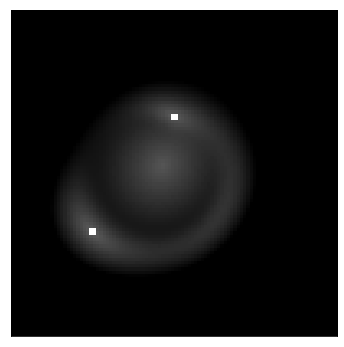

 50%|█████     | 2/4 [00:00<00:00,  5.99it/s]

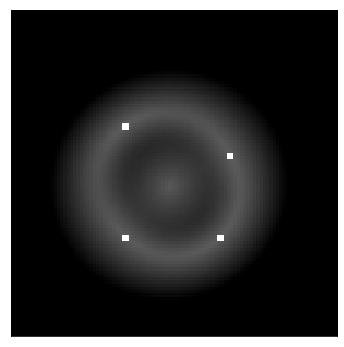

 75%|███████▌  | 3/4 [00:00<00:00,  5.53it/s]

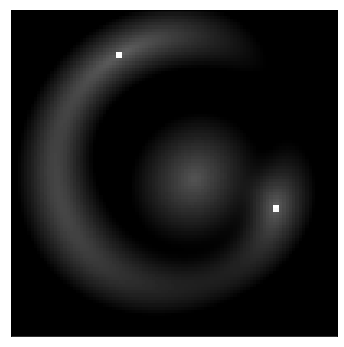

100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

['img_path' 'theta_E' 'gamma' 'center_x' 'center_y' 'e1' 'e2' 'gamma_ext'
 'psi_ext' 'source_center_x' 'source_center_y' 'source_n_sersic'
 'source_R_sersic' 'source_e1' 'source_e2' 'lens_light_e1' 'lens_light_e2'
 'lens_light_n_sersic' 'lens_light_R_sersic']


In [53]:
_lens_keys = ['theta_E', 'gamma', 'center_x', 'center_y', 'e1', 'e2', 'gamma_ext', 'psi_ext']
_source_keys = ['source_center_x', 'source_center_y', 'source_n_sersic', 'source_R_sersic', 'source_e1', 'source_e2']
_light_model_keys = ['lens_light_e1', 'lens_light_e2', 'lens_light_n_sersic', 'lens_light_R_sersic']
meta_keys = ['img_path', *_lens_keys, *_source_keys, *_light_model_keys]
meta_df = {key: np.zeros(num_sample) for key in meta_keys}
meta_df['img_path'] = ['placeholder'] * num_sample



for i in tqdm(range(num_sample)):

    # Generate the coordinate grid and image properties kwargs
    kwargs_data = sim_util.data_configure_simple(
        numPix, 
        deltaPix,
        exposure_time=500.0, #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        sigma_bkg=0.05, #  background noise per pixel (Gaussian)
    )
    image_data_class = ImageData(**kwargs_data)

    kwargs_psf = {
        'psf_type': 'GAUSSIAN', 
        'fwhm': 0.005,  # full width at half maximum of PSF
        'pixel_size': deltaPix, 
        'truncation': 3,
    }
    psf_class = PSF(**kwargs_psf)


    # Mean of the BNN prior: mass distribution for the lens system (all kinds of mass: dm halo + galaxy )
    gamma_ext_mu, gamma_ext_sigma = 0.015, 0.005
    theta_E_mu, theta_E_sigma = 1.25, 0.4
    gamma_mu, gamma_sigma = 2.0, 0.05
    center_mu, center_sigma = 0.0, 0.2
    e_mu, e_sigma = 0.0, 0.2
    model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']

    gamma_ext = np.maximum(np.random.normal(gamma_ext_mu, gamma_ext_sigma), 0)
    theta_E = np.maximum(np.random.normal(loc=theta_E_mu, scale=theta_E_sigma), 0.1)
    gamma = np.maximum(np.random.normal(gamma_mu, gamma_sigma), 1.85)
    center_x = np.random.normal(center_mu, center_sigma)
    center_y = np.random.normal(center_mu, center_sigma)
    e1 = np.minimum(np.random.normal(e_mu, e_sigma), 0.9)
    e2 = np.minimum(np.random.normal(e_mu, e_sigma), 0.9)

    psi_ext = np.random.uniform(0.0, 2.*np.pi)

    kwargs_shear = {
        'gamma_ext': gamma_ext, 
        'psi_ext': psi_ext,
    }  # shear values to the source plane
    kwargs_spemd = {
        'theta_E': theta_E, 
        'gamma': gamma, 
        'center_x': center_x, 
        'center_y': center_y, 
        'e1': e1, 
        'e2': e2,
    }  # parameters of the deflector lens model

    lens_model = LensModel(lens_model_list=model_list)
    lens_model_kwargs = [kwargs_spemd, kwargs_shear]


    # lens light model
    lens_light_config = {
        'phi_G': 0.9,
        'q': 0.9,
        'R_sersic_mu': 0.3,
        'R_sersic_sigma': 0.1,
        'n_sersic_mu': 1.0,
        'n_sersic_sigma': 0.1,
        'amp': 0.8,
        'center_x': center_x,  # taken from lens
        'center_y': center_y,  # taken from lens
        'model_list': ['SERSIC_ELLIPSE'],
    }
    light_model, light_model_kwargs = create_light_model(**lens_light_config)

    position_mu, position_sigma = 0.0, 0.1
    source_position = {
        'x': np.random.normal(position_mu, position_sigma),
        'y': np.random.normal(position_mu, position_sigma),
    }

    # source light model
    source_sersic_config = {
        'phi_G': 0.5,
        'q': 0.8,
        'R_sersic_mu': 0.2,
        'R_sersic_sigma': 0.1,
        'n_sersic_mu': 1.0,
        'n_sersic_sigma': 0.1,
        'amp': 1.2,
        'center_x': source_position['x'],
        'center_y': source_position['y'],
        'model_list': ['SERSIC_ELLIPSE'],
    }
    source_model, source_model_kwargs = create_light_model(**source_sersic_config)


    # quasar point source model
    point_source_model, point_source_model_kwargs = create_point_source_model(lens_model, lens_model_kwargs, source_position)

    # not sure what this is for
    kwargs_numerics = {'supersampling_factor': 1}

    imageModel = ImageModel(
        image_data_class, 
        psf_class, 
        lens_model, 
        source_model,
        light_model, 
        point_source_model, 
        kwargs_numerics = kwargs_numerics,
    )

    # generate image
    img = imageModel.image(
        lens_model_kwargs, 
        source_model_kwargs, 
        light_model_kwargs, 
        point_source_model_kwargs,
    )
    #poisson = image_util.add_poisson(img, exp_time=exp_time)
    #bkg = image_util.add_background(img, sigma_bkd=sigma_bkg)
    img = img  # + bkg + poisson

    image_data_class.update_data(img)
    kwargs_data['image_data'] = img


    # visualize images
    if show_img == True:
        plot_image(img)


    # save image file
    img_path = dest_dir / f"X_{i:07d}.npy"  # changed to 0-index
    np.save(img_path, img)


    # fill in meta_df
    meta_df['img_path'][i] = img_path
    
    # lens keys
    _lens_dict = {
        **lens_model_kwargs[0],
        **lens_model_kwargs[1],
    }
    _source_dict = source_model_kwargs[0]
    _lens_lights_dict = light_model_kwargs[0]

    for key in _lens_keys:
        meta_df[key][i] = _lens_dict[key]

    for key in _source_keys:
        meta_df[key][i] = _source_dict[key.replace("source_", "")]

    for key in _light_model_keys:
        meta_df[key][i] = _lens_lights_dict[key.replace("lens_light_", "")]


# save meta data df as csv
meta_df = pd.DataFrame.from_dict(meta_df)
meta_path = os.path.join(dest_dir, 'metadata.csv')
meta_df.to_csv(meta_path, index=None)

print(meta_df.columns.values)